# Room for the river: Gorssel 

## Imports 

In [1]:
#imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
import time
import copy
import os
import functools
import random
import itertools

from ema_workbench import (Model, CategoricalParameter,ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, ema_logging, Constant, Policy, Scenario,
                           perform_experiments, SequentialEvaluator,Constraint)
from problem_formulation import get_model_for_problem_formulation
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress,GenerationalBorg)
from ema_workbench.em_framework.evaluators import (perform_experiments,BaseEvaluator)
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import plotting, plotting_util, parcoords, feature_scoring, prim
from ema_workbench import load_results 
from mpl_toolkits.mplot3d import Axes3D 
from sklearn import preprocessing
from concurrent.futures import (ProcessPoolExecutor,ThreadPoolExecutor)
from scipy.spatial.distance import pdist, squareform

In [27]:
def evaluate_diversity_single(indices, distances, weight=0.5, distance='euclidean'):
    '''
    takes the outcomes and selected scenario set (decision variables), 
    returns a single 'diversity' value for the scenario set.
    outcomes : outcomes dictionary of the scenario ensemble
    decision vars : indices of the scenario set
    weight : weight given to the mean in the diversity metric. If 0, only minimum; if 1, only mean
    '''
    i, j = [e for e in zip(*itertools.combinations(indices, 2))]
    subset_distances = distances[i, j]
    minimum = np.min(subset_distances)
    mean = np.mean(subset_distances)
    diversity = (1-weight)*minimum + weight*mean
    
    return [diversity]


def find_maxdiverse_scenarios(distances, combinations):
    scores = []
    for indices in combinations:
        diversity = evaluate_diversity_single(indices, distances)
        scores.append((diversity, indices))

    return scores

def optimize(scenario, nfe, model, converge_metrics, epsilons):
    #with SequentialEvaluator(model) as evaluator:
    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence

def entries_to_remove(entries, the_dict):
    for key in entries:
        if key in the_dict:
            del the_dict[key]

In [3]:
# import the correct dataframes of a long run with 1000 scenarios and 10 policies 
df_experiments_s1000_p10 = pd.read_csv("df_experiments_s1000_p10.csv")
df_outcomes_s1000_p10 = pd.read_csv("df_outcomes_s1000_p10.csv")

## Set experiments and outcomes 

In [4]:
#check the size of the dataframes 
print(df_experiments_s1000_p10.shape) 
print(df_outcomes_s1000_p10.shape)

(10000, 54)
(10000, 18)


In [5]:
#Run MORDM with the long run as imported, copy the data here so it doesn't have to be loaded in again 
experiments = df_experiments_s1000_p10.copy()
outcomes = df_outcomes_s1000_p10.copy()

# Scenario Selection 

### Choose outcomes of interest 

While running the code below the prolem occured that the size of the outcomes was too large. The following error appeared: "The kernel for Documents/GitHub/EPA1361_group16/MORDM.ipynb appears to have died. It will restart automatically.". To prevent this from happening the choice was made to decrease the number of outcomes that will be used to 100. Ideally this wouldn't be necessary, since a large part of the data is not being used now. This can be improved upon. 



In [6]:
#Making it possible to randomly select outcomes 
set_seed = 1234567 
random.seed(set_seed)

In [7]:
#with trial and error, the number of outcomes can be set to approximatly 100 to prevent the code from crashing 
number_of_outcomes = 100 
outcomes_of_interest = outcomes.sample(n=number_of_outcomes, random_state = set_seed)

y= (outcomes.index.isin(outcomes_of_interest.index))


In [8]:
experiments_of_interest = experiments.loc[y] 
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

#normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)

In [9]:
outcomes_of_interest.head()
experiments_of_interest.head()

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
106,106,31,321.087153,10.0,0.339356,94.394245,1.5,0.251813,194.392592,10.0,...,9,3,7,6,9,10,2,116,0,dikesnet
336,336,78,58.368824,1.5,0.585965,112.850913,10.0,0.609583,109.966911,1.0,...,9,3,7,6,9,10,2,346,0,dikesnet
490,490,116,221.408402,1.0,0.881096,96.943702,1.0,0.481245,238.827274,1.0,...,9,3,7,6,9,10,2,500,0,dikesnet
707,707,66,349.252960,1.5,0.565601,54.489702,10.0,0.399284,266.496110,10.0,...,9,3,7,6,9,10,2,717,0,dikesnet
744,744,93,278.838679,10.0,0.614562,142.773376,1.0,0.447878,213.345108,1.0,...,9,3,7,6,9,10,2,754,0,dikesnet


### Create Combinations 

In [10]:
n_scen = experiments.loc[y].shape[0]
indices = range(n_scen)
set_size = 5

n_scen
combinations = itertools.combinations(indices, set_size)
combinations = list(combinations)

In [11]:
len(combinations)

75287520

In [12]:
#Identify the most diverse scenarios 
distances = squareform(pdist(normalized_outcomes.values))

cores = os.cpu_count()
partial_function = functools.partial(find_maxdiverse_scenarios, distances)

with ThreadPoolExecutor(max_workers=cores) as executor: 
    worker_data = np.array_split(combinations, cores)
    results = [e for e in executor.map(partial_function, worker_data)]
    results = list(itertools.chain.from_iterable(results))

In [13]:
results.sort(key=lambda entry:entry[0], reverse=True)
most_diverse = results[0]
most_diverse

([2.188436271412426], array([14, 45, 87, 90, 91]))

### create scenarios 

In [1]:
selected = experiments.loc[most_diverse[1], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model']]
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

NameError: name 'experiments' is not defined

In [ ]:
scenarios

In [15]:
keys_policies = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', 
               '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', 
               '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 
              'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 
              'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 
              'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 
              'EWS_DaysToThreat', 'scenario', 'policy','model']

In [16]:
#create dictionary with only the uncertainties 
for i in range(0,5):
    entries_to_remove(keys_policies, scenarios[i]) 

scenarios

[Scenario({'A.0_ID flood wave shape': 22, 'A.1_Bmax': 181.16308821650483, 'A.1_Brate': 10.0, 'A.1_pfail': 0.5104251476977022, 'A.2_Bmax': 220.68878105905995, 'A.2_Brate': 10.0, 'A.2_pfail': 0.9786011735583656, 'A.3_Bmax': 218.1638917684424, 'A.3_Brate': 10.0, 'A.3_pfail': 0.4522507725200962, 'A.4_Bmax': 64.98261769390427, 'A.4_Brate': 1.0, 'A.4_pfail': 0.3837234873535599, 'A.5_Bmax': 167.88086310933343, 'A.5_Brate': 10.0, 'A.5_pfail': 0.1323735408571761, 'discount rate 0': 1.5, 'discount rate 1': 4.5, 'discount rate 2': 2.5}),
 Scenario({'A.0_ID flood wave shape': 117, 'A.1_Bmax': 242.9528297674285, 'A.1_Brate': 10.0, 'A.1_pfail': 0.4452023806799587, 'A.2_Bmax': 203.71891394602457, 'A.2_Brate': 1.0, 'A.2_pfail': 0.1579972966826894, 'A.3_Bmax': 85.60140905242505, 'A.3_Brate': 1.5, 'A.3_pfail': 0.3231152824709321, 'A.4_Bmax': 335.1887778239524, 'A.4_Brate': 1.0, 'A.4_pfail': 0.5415761667050393, 'A.5_Bmax': 30.373332625601503, 'A.5_Brate': 1.0, 'A.5_pfail': 0.4619960275175704, 'discount r

In [17]:
df_scenarios = pd.DataFrame(scenarios) 
df_scenarios.to_csv("scenarios_100_s1000_p10.csv") 

In [33]:
import pickle

a_file = open("scenarios_MSMORDM.pkl", "wb")
pickle.dump(scenarios, a_file)
a_file.close()

# Mordm Run 

### Hypervolume determination 

In [18]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 

In [28]:
start_seq_hyp = time.time()

In [29]:
results = []
nfes = 1e4 

for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=[0,]*len(dike_model.outcomes), 
                                       maximum=[1000,]*len(dike_model.outcomes)),
                           EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, nfes, dike_model, convergence_metrics, epsilons))


100%|████████████████████████████████████▉| 9972/10000 [57:48<00:10,  2.57it/s]
10072it [58:29,  2.87it/s]                                                     
[MainProcess/INFO] optimization completed, found 2695 solutions

100%|██████████████████████████████████▊| 9956/10000 [1:00:36<00:16,  2.62it/s]
16802it [1:42:20,  2.74it/s]                                                   
[MainProcess/INFO] optimization completed, found 4929 solutions

100%|██████████████████████████████████▉| 9976/10000 [1:01:02<00:09,  2.57it/s]
10075it [1:01:39,  2.72it/s]                                                   
[MainProcess/INFO] optimization completed, found 2555 solutions

100%|██████████████████████████████████▊| 9953/10000 [1:04:26<00:20,  2.29it/s]
10052it [1:05:06,  2.57it/s]                                                   
[MainProcess/INFO] optimization completed, found 2637 solutions

100%|██████████████████████████████████▉| 9972/10000 [1:02:38<00:10,  2.59it/s]
17274it [1:47:31,  

In [31]:
end_seq_hyp = time.time()
time_hyp = end_seq_hyp - start_seq_hyp
print(time_hyp) 

23840.73467206955


In [35]:
results

[(      0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
  0           0        0        1        0        0        0        0        1   
  1           1        1        0        1        0        1        0        1   
  2           1        0        1        0        0        1        1        0   
  3           1        1        0        1        1        1        1        0   
  4           0        0        0        1        1        0        1        0   
  ...       ...      ...      ...      ...      ...      ...      ...      ...   
  2690        0        0        0        1        0        0        0        0   
  2691        1        0        0        1        0        0        1        0   
  2692        0        1        0        0        0        0        0        0   
  2693        1        0        0        0        0        0        0        1   
  2694        0        0        1        0        1        0        0        0   
  
        2_RfR

In [32]:
import pickle

a_file = open("results_dict.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [24]:
df_results_firstscenario = pd.DataFrame(results_firstscenario) 
df_results_firstscenario.to_csv("results_firstscenario_hypervolume_noo100_nfe1000_s1000_p10.csv") #save the dataframes

In [34]:
df_results = pd.DataFrame(results) 
df_results.to_csv("results_hypervolume_noo100_nfe1000_s1000_p10.csv") #save the dataframes

## Plots 

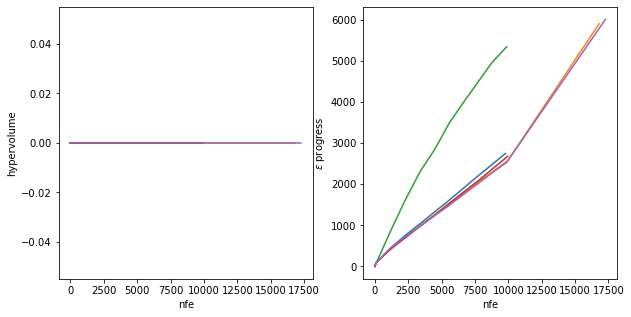

<Figure size 432x288 with 0 Axes>

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,5))
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
#fig.legend()
plt.show()
plt.savefig('Hypervol_noo100_nfe1e4_and_epsilon_0,1')

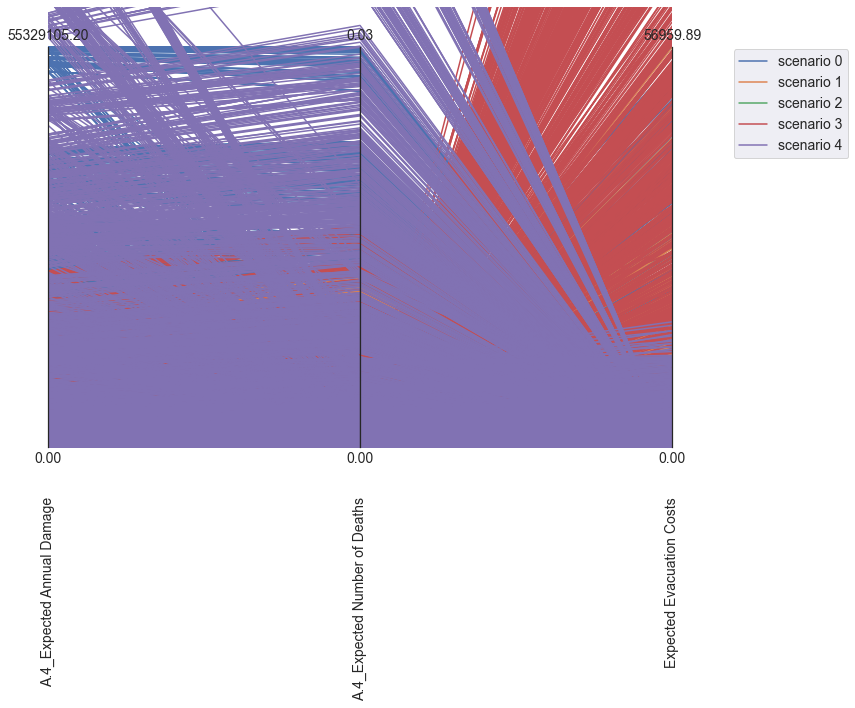

<Figure size 720x1080 with 0 Axes>

In [39]:
#determine thresholds based on the maxima that can be acquierd 


colors = iter(sns.color_palette())
data = results[0][0].iloc[:, 5::]

max_expected_annual_damage = float(data[['A.4_Expected Annual Damage']].max())
max_number_deaths = float(data[['A.4_Expected Number of Deaths']].max()) 
max_evacuation_costs = float(data[['Expected Evacuation Costs']].max()) 

limits = parcoords.get_limits(results[0][0].iloc[:, 5::][['A.4_Expected Annual Damage', 
                                'A.4_Expected Number of Deaths','Expected Evacuation Costs']])

limits.loc[0, 'A.4_Expected Annual Damage'] = max_expected_annual_damage
limits.loc[0, 'A.4_Expected Number of Deaths'] = max_number_deaths 
limits.loc[0, 'Expected Evacuation Costs'] = max_evacuation_costs 
limits.loc[1, :] = 0

paraxes = parcoords.ParallelAxes(limits)

for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    sns.set(rc = {'figure.figsize':(10,15)})
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()

plt.savefig('Tradeoffs__noo100_nfe1e4_eps_0,1')

## Deep Uncertainty 
Reevaluate under deep uncertainty 

In [40]:
#specify the policies 

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:31]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)
        

In [41]:
len(policies) #17685

17685

In [ ]:
#randomly select 50 policies 

sampled_policies = random.sample(policies, 50)

In [ ]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 

with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=sampled_policies)

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.



In [ ]:
experiments_deep, outcomes_deep = reeevaluation_results

#determine thresholds  
# max_expected_annual_damage = float(data[['A.4_Expected Annual Damage']].max())
# max_number_deaths = float(data[['A.4_Expected Number of Deaths']].max()) 
# max_evacuation_costs = float(data[['Expected Evacuation Costs']].max()) 

# max_expected_annual_damage = 9.28e+05
# max_number_deaths = 0.00009
# max_evacuation_costs = 4000

thresholds = {'A.4_Expected Number of Deaths':max_number_deaths, 
              'A.4_Expected Annual Damage':max_expected_annual_damage,
             'Expected Evacuation Costs':max_evacuation_costs}

overall_scores = {}
for policy in experiments_deep.policy.unique():
    logical = experiments_deep.policy == policy
    scores = {}
    for k, v in outcomes_deep.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [ ]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()